<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Machine_Learning/Tree_based/03-01-02-08-07-tree-based-models-bagging-grf-probability-forest-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 2.8.7 Probability Forest

A **Probability Forest** is a machine learning model based on the random forest framework, designed to estimate **conditional probabilities** for categorical outcomes. It extends the standard random forest classifier by outputting the probability of each class for a given set of covariates, rather than just predicting the most likely class. It is implemented in packages like `{grf}` in R (as `probability_forest`) and is particularly useful for tasks requiring probabilistic predictions, such as risk estimation or classification with uncertainty quantification. Below, I’ll explain what it is, how it works, and its key features, keeping it concise and clear.


## Overview

Probability Forest Estimates the conditional probability $P(Y = k | X)$) for each class $k$ of a categorical outcome $Y$, given covariates $X$. For example, it can predict the probability of a patient having a disease (yes/no) based on features like age or symptoms.




### Key Features

-   `Non-Parametric`: Captures complex, non-linear relationships between $X$ and $Y$.
-   `Robustness`: Averaging over many trees reduces overfitting and improves generalization.
-   `Heterogeneity`: Estimates probabilities that vary across individuals based on covariates.
-   `Calibration`: In `{grf}`, probabilities are well-calibrated due to honest estimation and local smoothing.
-   `Multi-Class Support`: Handles binary or multi-class outcomes seamlessly.


### How It Work

A Probability Forest builds on the random forest algorithm but focuses on estimating class probabilities. Here’s a step-by-step overview:

1.  Data Setup

   -   `Input`: Covariates $X$ (e.g., age, sex) and a categorical outcome $Y$ (e.g., 0/1 for binary, or multiple classes).
   -   $Y$ is typically a factor or integer vector indicating class labels.

2.  Tree Construction

   -   Like a standard random forest, it grows multiple decision trees (e.g., 1000).
   -   Each tree is trained on a random subset of data (bootstrap sampling) and features.
   -   At each node, splits are chosen to maximize the separation of classes (e.g., using Gini impurity or entropy).

3.  Probability Estimation:

  -   For each tree, the leaf nodes contain the proportion of training observations for each class.
  -   For a given input $X$ the tree assigns $X$ to a leaf, and the class proportions in that leaf are the estimated probabilities.
   -   The forest averages the probability estimates across all trees to produce $P(Y = k | X)$ for each class $k$.

4.  Output

  -   A matrix of probabilities for each observation and class, e.g., $[P(Y=0|X), P(Y=1|X)]$ for binary outcomes.
  -   Optionally, the predicted class (highest probability) can be derived.

5.  Honest Estimation (in `{grf}`):

   -   Uses`honest`splitting (separating data for tree structure and estimation) to reduce bias.
   -   Employs local maximum likelihood estimation within leaves for smoother probability estimates.

### Differences from Other Forests

-   `Vs. Regression Forest`: Estimates continuous outcomes ($E[Y|X]$), not probabilities for categorical outcomes.
-   `Vs. Causal Forest*` Focuses on treatment effect estimation ($E[Y(1) - Y(0)|X]$), not class probabilities.
-   `Vs. Standard Random Forest Classifier`: Outputs probabilities rather than just class predictions, with enhanced calibration in `{grf}`.



### Limitations

-   `Computational Cost`: Training many trees can be slow for large datasets.
-   `Interpretability`: Probabilities are data-driven but less interpretable than parametric models like logistic regression.
-   `Assumes Data Quality`: Requires sufficient data per class and no missing values in ( X ).

### Use Cases

-   `Scenario`: Predict the probability of patient survival (0 = no, 1 = yes) based on age, sex, and health metrics.
-   `Data`: $X$ = \[age, sex, health_score\], $Y$ = survival status (0/1).
-   `Output`: For a patient, the model might estimate $P(Y=1|X) = 0.75$, indicating a 75% chance of survival.

## Setup R in Python Runtype

### Install {rpy2}

{rpy2} is a Python package that provides an interface to the R programming language, allowing Python users to run R code, call R functions, and manipulate R objects directly from Python. It enables seamless integration between Python and R, leveraging R's statistical and graphical capabilities while using Python's flexibility. The package supports passing data between the two languages and is widely used for statistical analysis, data visualization, and machine learning tasks that benefit from R's specialized libraries.

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.17
Uninstalling rpy2-3.5.17:
  Successfully uninstalled rpy2-3.5.17
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp311-cp311-linux_x86_64.whl size=314980 sha256=96b61584f0c57b48a2a1a015c9fd1149549244befea9cdb64df47edc2ce3e252
  Stored in directory: /root/.cache/pip/wheels/e9/55/d1/47be85a5f3f1e1f4d1e91cb5e3a4dcb40dd72147f184c5a5ef
Successfully built rpy2


### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Probability Forest with R

This tutorial shows how to use `probability_forest()` function of {grf} package to estimate  $P(\text{health_status} = 1 | X)$, the probability of health improvement, for each patient in the lung dataset. We’ll cover data preparation, model fitting, prediction, and visualization of the estimated probabilities.



### Load and Check Required Libraries

In [3]:
%%R
packages <- c('tidyverse',
              'plyr',
              'grf',
              'rdd',
              'survival',
              'mlbench',
              'Metrics'
         )

### Install Missing Packages

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

### Verify Installation

In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:
tidyverse      plyr       grf       rdd  survival   mlbench   Metrics 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE 


### Load R Packages

In [4]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))


### Check Loaded Packages

In [ ]:
%%R
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packageswer)

Successfully loaded packages:
 [1] "package:rdd"       "package:Formula"   "package:AER"      
 [4] "package:car"       "package:carData"   "package:lmtest"   
 [7] "package:zoo"       "package:sandwich"  "package:Metrics"  
[10] "package:mlbench"   "package:survival"  "package:grf"      
[13] "package:plyr"      "package:lubridate" "package:forcats"  
[16] "package:stringr"   "package:dplyr"     "package:purrr"    
[19] "package:readr"     "package:tidyr"     "package:tibble"   
[22] "package:ggplot2"   "package:tidyverse" "package:tools"    
[25] "package:stats"     "package:graphics"  "package:grDevices"
[28] "package:utils"     "package:datasets"  "package:methods"  
[31] "package:base"     


### Load and Prepare the Lung Dataset

The lung dataset contains survival data for lung cancer patients with variables like `time` (survival time), `status` (censoring indicator), `age`, s`ex`, and `ph.ecog` (ECOG performance score). We’ll simulate a binary `health_status `variable (1 = improved, 0 = not improved) and use age, sex, and ph.ecog as covariates.


In [5]:
%%R
# Set seed for reproducibility
set.seed(123)

# Load and prepare lung dataset
data(lung)
lung_data <- lung %>%
  dplyr::filter(!is.na(age), !is.na(sex), !is.na(ph.ecog)) %>%
  dplyr::mutate(
    health_status = rbinom(n(), 1, prob = 0.3 + 0.1 * (ph.ecog < 2) + 0.05 * (sex == 1)),
    health_status = as.factor(health_status)
  )

# Define covariates and outcome
X <- lung_data %>% select(age, sex, ph.ecog) %>% as.matrix()
Y <- lung_data$health_status

# Verify inputs
cat("Outcome levels:", levels(Y), "\n")
str(Y)
str(X)

Outcome levels: 0 1 
 Factor w/ 2 levels "0","1": 1 2 1 2 2 1 1 2 2 1 ...
 num [1:227, 1:3] 74 68 56 57 60 74 68 71 53 61 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:227] "1" "2" "3" "4" ...
  ..$ : chr [1:3] "age" "sex" "ph.ecog"


### Fit Probability Forest Model

We use `probability_forest()` from the `{grf}` package to fit a Probability Forest model. We specify parameters like the number of trees, honesty, minimum node size, and number of threads for parallel processing.

In [7]:
%%R
# Fit probability forest
pf <- probability_forest(
  X = X,
  Y = Y,
  num.trees = 1000,
  honesty = TRUE,
  min.node.size = 5,
  num.threads = parallel::detectCores() - 1
)
pf

GRF forest object of type probability_forest 
Number of trees: 1000 
Number of training samples: 227 
Variable importance: 
    1     2     3 
0.604 0.141 0.255 


### Predict Probabilities and Variance Estimates

In [8]:
%%R

# Predict probabilities
probs <- predict(pf, estimate.variance = TRUE)

# Debug: Inspect prediction structure
cat("Structure of probs$predictions:\n")
str(probs$predictions)
cat("Column names of probs$predictions:\n")
colnames(probs$predictions)

Structure of probs$predictions:
 num [1:227, 1:2] 0.655 0.603 0.404 0.591 0.499 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:2] "0" "1"
Column names of probs$predictions:
[1] "0" "1"


### Extract Predictions

In [9]:
%%R
# Extract predictions into a data frame
results <- data.frame(
  patient_id = 1:nrow(X),
  age = lung_data$age,
  prob_health_improved = probs$predictions[, "1"],
  variance = probs$variance.estimates[, "1"]
)

# Summarize average probability
summary_results <- results %>%
  summarise(
    avg_prob_health_improved = mean(prob_health_improved, na.rm = TRUE),
    avg_variance = mean(variance, na.rm = TRUE)
  )

print(summary_results)

  avg_prob_health_improved avg_variance
1                 0.399526  0.009110781


### Visualize Probability of Health Improvement by Age

`geom_smooth()` using formula = 'y ~ x'


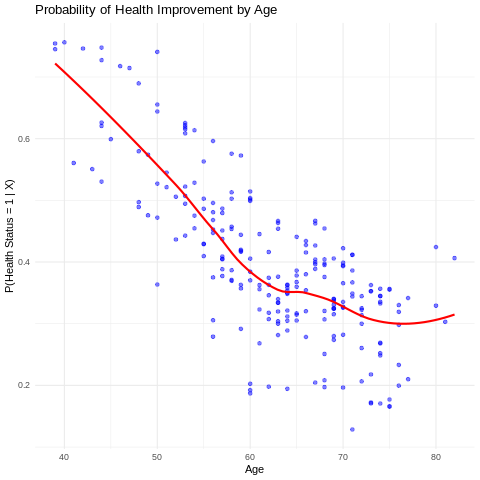

In [10]:
%%R
# Plot probability of health improvement by age
ggplot(data = results, aes(x = age)) +
  geom_point(aes(y = prob_health_improved), color = "blue", alpha = 0.5) +
  geom_smooth(aes(y = prob_health_improved), method = "loess", se = FALSE, color = "red") +
  labs(title = "Probability of Health Improvement by Age",
       x = "Age", y = "P(Health Status = 1 | X)") +
  theme_minimal()

## Summary and Conclusion

Probability Forests are a powerful tool for estimating conditional probabilities in classification tasks. They extend the random forest framework to provide probabilistic outputs, making them suitable for applications requiring uncertainty quantification. By averaging predictions across multiple trees, they offer robust and flexible estimates that can handle complex relationships between covariates and outcomes. This tutorial demonstrated how to implement a Probability Forest using the `{grf}` package in R, showcasing its ability to predict the probability of health improvement based on patient characteristics.
  


## References

1. [Probabilty Forest](https://grf-labs.github.io/grf/reference/probability_forest.html)